In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR, MultiplicativeLR, ExponentialLR
import torch.nn.functional as F
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns


### Preprocessing the separated Training Data for training and validation

In [2]:
# read the separated training data into df

test_df = pd.read_excel(r'C:\Users\MKK_Forschung\Documents\trend_pulse_data\Test_data.xlsx')

In [3]:
main_dir = r'C:\Users\MKK_Forschung\Documents\trend_pulse_data\new_exp'
experiment = 'Exp_gpu_1'
exp_dir = os.path.join(main_dir, experiment)
weights_dir = os.path.join(exp_dir, 'model_weights')
log_path = os.path.join(exp_dir, 'Training_log.txt')
os.makedirs(weights_dir, exist_ok=True)

In [4]:
# Load the product encoding dictionary
with open(os.path.join(exp_dir,'product_to_index.pkl'), 'rb') as f:
    product_to_index = pickle.load(f)

# Load the main category encoding dictionary
with open(os.path.join(exp_dir,'main_category_to_index.pkl'), 'rb') as f:
    main_category_to_index = pickle.load(f)

# Load the subcategory encoding dictionary
with open(os.path.join(exp_dir,'sub_category_to_index.pkl'), 'rb') as f:
    sub_category_to_index = pickle.load(f)

In [5]:
# Step 1: Use ecoding Mappings to encode the test data
# Encode the products using the loaded dictionary
test_df['encoded_product'] = test_df['product'].map(product_to_index)

# Encode the main categories using the loaded dictionary
test_df['encoded_main_category'] = test_df['main_category'].map(main_category_to_index)

# Encode the subcategories using the loaded dictionary
test_df['encoded_sub_category'] = test_df['sub_category'].map(sub_category_to_index)

# Handle any potential missing values (e.g., if a test category is not found in the dictionary)
# You can either fill with a default value or handle them as necessary.
test_df['encoded_product'] = test_df['encoded_product'].fillna(-1).astype(int)
test_df['encoded_main_category'] = test_df['encoded_main_category'].fillna(-1).astype(int)
test_df['encoded_sub_category'] = test_df['encoded_sub_category'].fillna(-1).astype(int)


# Create the int_rating column using a lambda function with three categories of ratings
test_df['int_rating'] = test_df['ratings'].apply(lambda x: 0 if x <= 2.5 else (1 if x <= 4.0 else 2))


# Convert prices from rupees to USD
test_df['actual_price'] = test_df['actual_price'] / 83
test_df['discount_price'] = test_df['discount_price'] / 83

In [6]:

# Optional: Process the 'link' column if necessary or drop it
# df = train_df.drop(columns=['link'])

# Step 2: Normalize numerical columns
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the numerical features
test_df[['ratings', 'no_of_ratings', 'actual_price', 'discount_price']] = scaler.fit_transform(test_df[['ratings', 'no_of_ratings', 'actual_price', 'discount_price']])


In [7]:
import torch

# Convert training data to PyTorch tensors
test_product_ids = torch.tensor(test_df['encoded_product'].values, dtype=torch.long)
test_category_ids = torch.tensor(test_df['encoded_main_category'].values, dtype=torch.long)
test_subcategory_ids = torch.tensor(test_df['encoded_sub_category'].values, dtype=torch.long)
test_ratings = torch.tensor(test_df['ratings'].values, dtype=torch.float32).view(-1, 1)
test_no_of_ratings = torch.tensor(test_df['no_of_ratings'].values, dtype=torch.float32).view(-1, 1)
test_actual_price = torch.tensor(test_df['actual_price'].values, dtype=torch.float32).view(-1, 1)
test_discount_price = torch.tensor(test_df['discount_price'].values, dtype=torch.float32).view(-1, 1)
test_labels = torch.tensor(test_df['int_rating'].values, dtype=torch.long)  # CrossEntropyLoss expects long dtype for labels


In [8]:
# Combine tensors into TensorDatasets
# test_dataset = TensorDataset(test_product_ids, test_category_ids, test_subcategory_ids, test_ratings, test_no_of_ratings, test_actual_price, test_discount_price, test_labels)
test_dataset = TensorDataset(test_category_ids, test_subcategory_ids, test_ratings, test_no_of_ratings, test_actual_price, test_discount_price, test_labels)

# Create DataLoaders for batching
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [9]:
# Check the first batch from the training DataLoader
for batch in test_loader:
    print(batch)
    break

[tensor([9, 8, 7, 7, 1, 1, 3, 4, 5, 9, 8, 3, 2, 0, 0, 1, 4, 8, 6, 0, 4, 4, 6, 4,
        4, 0, 1, 3, 1, 4, 0, 0]), tensor([11,  9,  8,  8,  1,  1,  4,  5,  6, 11,  9,  4,  2,  0,  0,  1,  5,  9,
         7,  0,  5,  5,  7,  5,  5,  0,  1,  3,  1,  5,  0,  0]), tensor([[-1.0966],
        [ 0.5374],
        [-0.5519],
        [-1.2328],
        [-0.2796],
        [ 0.2651],
        [-0.4158],
        [ 0.6736],
        [-1.2328],
        [-0.0072],
        [ 0.6736],
        [-0.8243],
        [ 1.4906],
        [ 0.6736],
        [ 1.4906],
        [ 0.1289],
        [ 1.4906],
        [ 0.5374],
        [ 0.1289],
        [-0.6881],
        [ 0.1289],
        [ 0.5374],
        [-0.2796],
        [ 0.6736],
        [ 0.1289],
        [-2.5945],
        [-0.9604],
        [-0.5519],
        [ 1.4906],
        [ 0.8098],
        [ 0.9460],
        [ 0.5374]]), tensor([[-1.5567e-01],
        [-4.5546e-02],
        [-1.7120e-01],
        [-1.7120e-01],
        [-1.6970e-01],
        [-1.68

### Model and Dataset class Definition

In [10]:
import torch
import torch.nn as nn

class RecommendationModel(nn.Module):
    def __init__(self, num_categories, num_subcategories, embedding_dim=10):
        super(RecommendationModel, self).__init__()
        
        # Embedding layers for categorical features
        self.category_embedding = nn.Embedding(num_categories, embedding_dim // 2)
        self.subcategory_embedding = nn.Embedding(num_subcategories, embedding_dim // 2)
        
        # Increase the output size of fc1 for more capacity
        self.fc1 = nn.Linear((embedding_dim // 2) * 2 + 4, 64)  # Increased from 128 to 256 units
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(64, 32)  # Adjust subsequent layers accordingly
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(32, 16)
        self.dropout3 = nn.Dropout(0.3)
        
        self.fc4 = nn.Linear(16, 8)
        self.dropout4 = nn.Dropout(0.3)

        # self.fc5 = nn.Linear(32, 16)
        # # self.dropout5 = nn.Dropout(0.1)
        
        # self.fc6 = nn.Linear(16, 8)
        # # self.dropout6 = nn.Dropout(0.1)
        
        self.fc5 = nn.Linear(8, 3)  # Output layer with 3 units for 3 classes

    def forward(self, category_id, subcategory_id, ratings, no_of_ratings, actual_price, discount_price):
        # Pass inputs through embeddings
        category_embedded = self.category_embedding(category_id)
        subcategory_embedded = self.subcategory_embedding(subcategory_id)
        
        # Flatten the embedding outputs
        category_embedded = category_embedded.view(-1, self.category_embedding.embedding_dim)
        subcategory_embedded = subcategory_embedded.view(-1, self.subcategory_embedding.embedding_dim)
        
        # Concatenate all features (embeddings + numerical features)
        concatenated = torch.cat((category_embedded, subcategory_embedded, ratings, no_of_ratings, actual_price, discount_price), dim=1)
        
        # Pass through fully connected layers with ReLU activation
        x = torch.relu(self.fc1(concatenated))
        x = self.dropout1(x)
        
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        
        x = torch.relu(self.fc4(x))
        # x = self.dropout4(x)
        
        # x = torch.relu(self.fc5(x))
        # # x = self.dropout5(x)
        
        # x = torch.relu(self.fc6(x))
        # # x = self.dropout6(x)
        
        output = self.fc5(x)  # Output layer
        
        return output


In [11]:
# Initialize metrics trackers
def compute_accuracy(predictions, labels):
    _, predicted = torch.max(predictions, 1)
    return accuracy_score(labels.cpu().numpy(), predicted.cpu().numpy())

def compute_auc(predictions, labels, num_classes):
    predictions_prob = F.softmax(predictions, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    if num_classes == 2:
        return roc_auc_score(labels, predictions_prob[:, 1])  # For binary classification
    else:
        return roc_auc_score(labels, predictions_prob, multi_class='ovr')  # For multi-class classification
    
def logging(log_path, log_text):
    with open(log_path, 'a') as file:
        file.write(log_text + '\n')
        
        
# Function to calculate and plot AUC-ROC
def calculate_and_plot_average_auc_roc(test_labels, test_probs, num_classes):
    # Binarize the labels for all classes
    true_labels_one_hot = np.eye(num_classes)[test_labels]
    
    # Calculate the micro-average ROC curve and AUC
    fpr, tpr, _ = roc_curve(true_labels_one_hot.ravel(), test_probs.ravel())
    average_auc = roc_auc_score(true_labels_one_hot, test_probs, average='micro')

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'Average AUC (micro) = {average_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return average_auc


def plot_confusion_matrix(test_labels, test_preds, class_names):
    """
    Plots the confusion matrix.
    
    Args:
    - test_labels: True labels for the test data.
    - test_preds: Predicted labels for the test data.
    - class_names: List of class names.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(test_labels, test_preds)
    
    # Create a DataFrame for better visualization
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


### Creating Data Loaders

### Model initialization and Training parameters

In [12]:
# RecommendationModel(
#   (product_embedding): Embedding(28588, 10)
#   (category_embedding): Embedding(10, 5)
#   (subcategory_embedding): Embedding(12, 5)
#   (fc1): Linear(in_features=24, out_features=64, bias=True)
#   (fc2): Linear(in_features=64, out_features=32, bias=True)
#   (fc3): Linear(in_features=32, out_features=3, bias=True)
# )


# Initialize the model
# num_products = 28588    # len(df['encoded_product'].unique())
num_categories = 10     # len(df['encoded_main_category'].unique())
num_subcategories = 12  #  len(df['encoded_sub_category'].unique())

# model = RecommendationModel(num_products, num_categories, num_subcategories)
model = RecommendationModel(num_categories, num_subcategories, embedding_dim=10)

model.load_state_dict(torch.load(os.path.join(weights_dir, 'best_model.pth')))



<All keys matched successfully>

In [13]:
print(model)

RecommendationModel(
  (category_embedding): Embedding(10, 5)
  (subcategory_embedding): Embedding(12, 5)
  (fc1): Linear(in_features=14, out_features=64, bias=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (dropout3): Dropout(p=0.4, inplace=False)
  (fc4): Linear(in_features=16, out_features=8, bias=True)
  (fc5): Linear(in_features=8, out_features=3, bias=True)
)


### Testing Loop

Using device: cpu


C:\Users\Data_Science\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Final Test Metrics:

Accuracy: 0.9516
Precision: 0.9062
Recall: 0.9516
F1 Score: 0.9283
Confusion Matrix:
[[   0  207  146]
 [   0 3689    6]
 [   0    0 3362]]
Testing Complete !!!


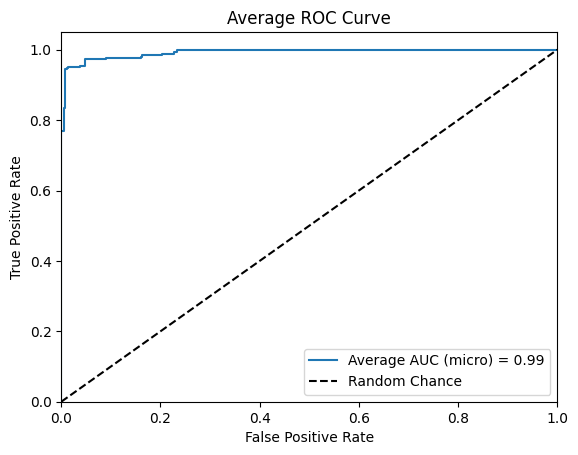

Average AUC: 0.9927
Average AUC: 0.9927


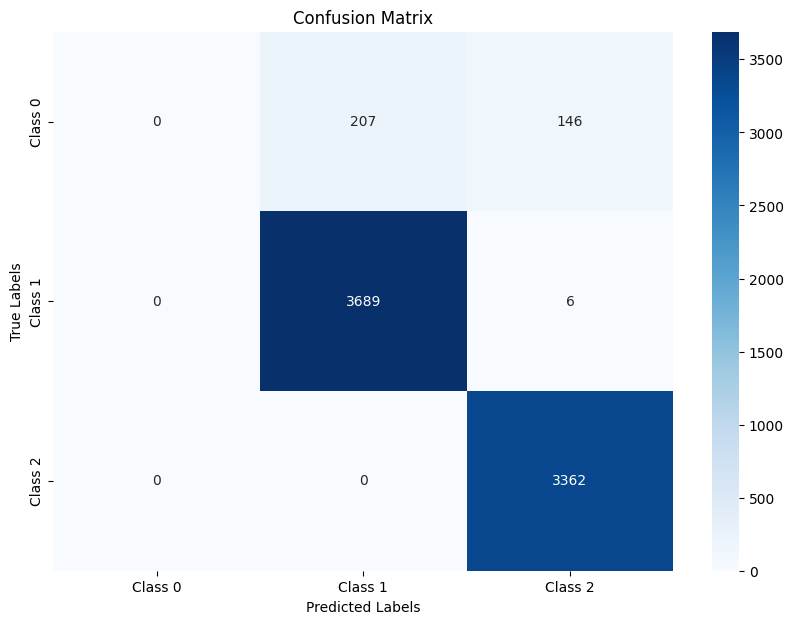

In [14]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


model = model.to(device)  # Move model to the appropriate device

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

model.eval()  # Set model to evaluation mode

# Initialize lists to store probabilities and labels
test_probs = []
test_preds = []
test_labels = []

# Testing loop
with torch.no_grad():  # Disable gradient computation
    for batch in test_loader:
        # Unpack batch data
        # product_id, category_id, subcategory_id, ratings, no_of_ratings, actual_price, discount_price, labels = batch
        category_id, subcategory_id, ratings, no_of_ratings, actual_price, discount_price, labels = batch
        
        # Move data to the appropriate device
        # product_id, category_id, subcategory_id = product_id.to(device), category_id.to(device), subcategory_id.to(device)
        category_id, subcategory_id = category_id.to(device), subcategory_id.to(device)

        ratings, no_of_ratings = ratings.to(device), no_of_ratings.to(device)
        actual_price, discount_price = actual_price.to(device), discount_price.to(device)
        labels = labels.to(device)
        
        # Forward pass
        # outputs = model(product_id, category_id, subcategory_id, ratings, no_of_ratings, actual_price, discount_price)
        outputs = model(category_id, subcategory_id, ratings, no_of_ratings, actual_price, discount_price)
        
        # Apply softmax to get probabilities
        probs = F.softmax(outputs, dim=1)
        preds = probs.argmax(dim=1)
        
        # Store probabilities, predictions, and labels
        test_probs.append(probs.cpu())
        test_preds.append(preds.cpu())
        test_labels.append(labels.cpu())

# Concatenate results across all batches
test_probs = torch.cat(test_probs)
test_preds = torch.cat(test_preds)
test_labels = torch.cat(test_labels)

# Convert to numpy arrays for metrics calculation and saving
test_probs_np = test_probs.numpy()
test_preds_np = test_preds.numpy()
test_labels_np = test_labels.numpy()

# Calculate metrics
accuracy = accuracy_score(test_labels_np, test_preds_np)
precision = precision_score(test_labels_np, test_preds_np, average='weighted')
recall = recall_score(test_labels_np, test_preds_np, average='weighted')
f1 = f1_score(test_labels_np, test_preds_np, average='weighted')
conf_matrix = confusion_matrix(test_labels_np, test_preds_np)

# Print metrics
print(f'Final Test Metrics:\n')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

# Create a DataFrame to store results
test_prob_df = pd.DataFrame(test_probs_np, columns=[f'prob_class_{i}' for i in range(test_probs_np.shape[1])])
test_prob_df['predictions'] = test_preds_np
test_prob_df['labels'] = test_labels_np

# Save the results to an Excel file
test_prob_df.to_excel(os.path.join(exp_dir, 'test_data_predictions.xlsx'), index=False)

print('Testing Complete !!!')

# Calculate the AUC for all classes and plot ROC curves
num_classes = test_probs_np.shape[1]
average_auc = calculate_and_plot_average_auc_roc(test_labels_np, test_probs_np, num_classes)
print(f'Average AUC: {average_auc:.4f}')

# Print the average AUC
print(f'Average AUC: {average_auc:.4f}')


class_names = [f'Class {i}' for i in range(num_classes)]

# plot the confusion matrix
plot_confusion_matrix(test_labels_np, test_preds_np, class_names)